### Imports and dependencies

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")

### Get dataframes by meterids and obtain list of meterids.

In [112]:
df_all = pd.read_csv('data/dataport-export_gas_oct2015-mar2016.csv')
df_all = df_all.set_index(pd.to_datetime(df_all['localminute']))
df_all = df_all.drop(columns='localminute')
groups = df_all.groupby('dataid')
keys = groups.groups.keys()  # keys: an iterable of dataids or meter ids
keys_list = list(keys)
print(keys_list)

[35, 44, 77, 94, 114, 187, 222, 252, 370, 483, 484, 661, 739, 744, 871, 1042, 1086, 1103, 1185, 1283, 1403, 1415, 1507, 1556, 1589, 1619, 1697, 1714, 1718, 1790, 1791, 1792, 1800, 1801, 2018, 2034, 2072, 2094, 2129, 2233, 2335, 2378, 2449, 2461, 2470, 2575, 2638, 2645, 2755, 2814, 2818, 2945, 2946, 2965, 2980, 3036, 3039, 3134, 3310, 3367, 3527, 3544, 3577, 3635, 3723, 3778, 3849, 3893, 3918, 4029, 4031, 4193, 4228, 4296, 4352, 4356, 4373, 4421, 4447, 4514, 4671, 4732, 4767, 4874, 4998, 5129, 5131, 5193, 5275, 5317, 5395, 5403, 5439, 5484, 5545, 5636, 5658, 5785, 5810, 5814, 5892, 5972, 6101, 6412, 6505, 6578, 6673, 6685, 6830, 6836, 6863, 6910, 7016, 7017, 7030, 7117, 7287, 7429, 7460, 7566, 7674, 7682, 7739, 7741, 7794, 7900, 7919, 7965, 7989, 8059, 8084, 8086, 8155, 8156, 8244, 8386, 8467, 8703, 8829, 8890, 8967, 9052, 9121, 9134, 9160, 9278, 9295, 9474, 9600, 9620, 9631, 9639, 9729, 9766, 9849, 9956, 9982]


In [113]:
def zoom(df, start_date, end_date):
    # returns a df whose rows are within a particular time period. 
    # pre-condition: df is indexed by datetime.
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    mask = (df.index >= start_date) & (df.index <= end_date)

    new_df = df.iloc[mask]
    return new_df

13796

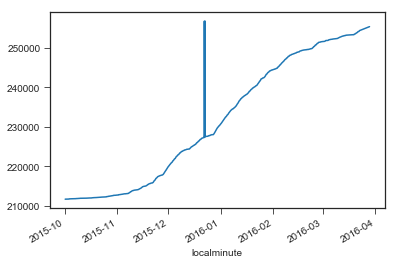

In [114]:
key = 9639
df_i = groups.get_group(key)
df_i['meter_value'].plot()
display(len(df_i))

In [115]:
# example for zoom
df_i_1mth = zoom(df_i, '2016-01-01', '2016-02-01')

### Cleaning steps.

In [116]:
# step 1 (optional part)
def remove_mal_data(df):
    # this method finds the start datetime and end datetime of the malfunctioning period and returns a new df without data
    # from that period. i.e. the entire chunk of data from the faulty period is dropped.
    # NOTE that a new column 'marginal_change' is added to the df.
    # df: pandas dataframe. contains data from one meterid. contains a column 'meter_value'.
    
    # from visualising the data, we can arbitrarily define a spike as a marginal change of > 2000 cubic metres
    # we have defined malfunction as a marginal change > 2000
    # and a marginal change < -2000. this should correspond to the period of 7-14 dec for particular meterids.
    threshold = 2000
    df = df.assign(marginal_change=df['meter_value'].diff().fillna(0))
    
    flagged_dates = df[df.marginal_change > threshold].index
    flagged_dates = flagged_dates.append(df[df.marginal_change < -1*threshold].index)
    
    if len(flagged_dates) > 0:
        start = flagged_dates[0]
        end = flagged_dates[-1]    
        mask = (df.index >= start) & (df.index <= end)
        return df.loc[~mask]
    else:
        return df

13748

,dataid,meter_value,marginal_change
localminute,,,
2015-10-01 05:06:36,9639,211656,0.0
2015-10-01 05:07:51,9639,211656,0.0
2015-10-01 05:11:36,9639,211656,0.0
2015-10-01 05:24:37,9639,211656,0.0
2015-10-01 05:29:37,9639,211656,0.0


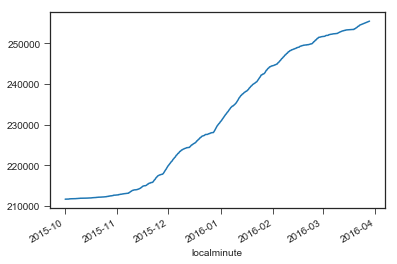

In [117]:
df_no_mal = remove_mal_data(df_i)
display(len(df_no_mal), df_no_mal.head())
df_no_mal['meter_value'].plot()

In [118]:
# step 2. exclude meters with low sampling frequency

# list of meters visually inspected and identified to be malfunctioning 
# based on spikes or irregularities seen on the plot.
# to_remove = [1185, 1556, 2335, 2449, 3134, 3544, 4447, 4514,\
#              5129, 5403, 6836, 7030, 7117, 8156, 9134, 9639, 9982]

# low_samplefreq = [1874, 2645, 4671, 5545, 6101, 9620]

# to_remove.extend(low_samplefreq) 

# display(to_remove, len(to_remove))

# # final meters to use for analysis
# to_keep = [elem for elem in keys_list if elem not in to_remove]

In [119]:
# step 3. Change cumulative to marginal change.

# we already have the 'marginal_change' column. 
# NOTE: the 'meter_value' or cumulative reading column is NO LONGER VALID after dropping any row.
# the only exception is for the very first row which is the first cumulative reading.
# if we are going to need cumulative readings again, we must construct them from this first cumulative reading and all
# the new (remaining/cleaned) marginal changes.

In [120]:
# step 4. remove marginal decrease.
def remove_negative_marginal(df):
    # remove data points where the marginal change (from prev value) is negative.
    return df.loc[df['marginal_change'] >= 0]

# same notes apply as in step 3.

In [121]:
df_no_negative_marginal = remove_negative_marginal(df_no_mal)
display(len(df_no_negative_marginal), df_no_negative_marginal.tail())

13748

,dataid,meter_value,marginal_change
localminute,,,
2016-03-22 13:19:41.004039,9639,254328,0.0
2016-03-22 13:30:41.506136,9639,254338,10.0
2016-03-22 13:30:56.006231,9639,254338,0.0
2016-03-22 17:25:10.992863,9639,254410,72.0
2016-03-28 14:52:54.831078,9639,255418,1008.0


In [122]:
# step 5. Get rate of increase from marginal changes (per second)

# df is a dataframe containing data for all meters excluding the ones that have been marked as malfunctioning
# structure of df is as such:
#
# localminute | dataid | meter_value | marginal_change
#
# where localminute is the index of the dataframe

def get_rate_of_increase(df_i):
    '''
    compute marginal rate of increase for each reading in df_i, assigning these values to a new column.
    
    groups: groupby object. meter values grouped by dataid (meterid).
    keys_list: list. list of meterids to operate on.
    '''
    rate_list = []
    prev_time = df_i.index[0]

    for i in range(len(df_i.index)):
        curr_time = df_i.index[i]
        if i == 0:
            rate_list.append(0)
        else:
            # get the marginal increase from the dataframe; if dataframe structure is changed index has to be also changed
            marginal_increase = df_i.iloc[i][2]

            # if else statement should not be necessary here if previous steps done correctly but added as a precaution
            if marginal_increase > 0:
                # get the elapsed time in seconds
                time_elapsed = curr_time - prev_time
                time_elapsed_in_sec = time_elapsed.total_seconds()

                # calculate the rate = marginal increase / elapsed time
                rate = marginal_increase / time_elapsed_in_sec
                rate_list.append(rate)
            else:
                rate_list.append(0)

        prev_time = curr_time
    
    # add extra column to the dataframe to record the rate of increase
    df_i = df_i.assign(marginal_rate=rate_list)
    return df_i

In [123]:
df_new = get_rate_of_increase(df_no_negative_marginal)
df_new.tail()

,dataid,meter_value,marginal_change,marginal_rate
localminute,,,,
2016-03-22 13:19:41.004039,9639,254328,0.0,0.000000
2016-03-22 13:30:41.506136,9639,254338,10.0,0.015140
2016-03-22 13:30:56.006231,9639,254338,0.0,0.000000
2016-03-22 17:25:10.992863,9639,254410,72.0,0.005123
2016-03-28 14:52:54.831078,9639,255418,1008.0,0.001979


In [124]:
# step 6 & 7. Mark anomalies from rate of increase with threshold = 0.166/s and remove them
def remove_large_increments(df):
    return df.loc[df.marginal_rate < 0.166]

In [125]:
df_clean = remove_large_increments(df_new)
display(len(df_clean), df_clean.head())

13748

,dataid,meter_value,marginal_change,marginal_rate
localminute,,,,
2015-10-01 05:06:36,9639,211656,0.0,0.0
2015-10-01 05:07:51,9639,211656,0.0,0.0
2015-10-01 05:11:36,9639,211656,0.0,0.0
2015-10-01 05:24:37,9639,211656,0.0,0.0
2015-10-01 05:29:37,9639,211656,0.0,0.0


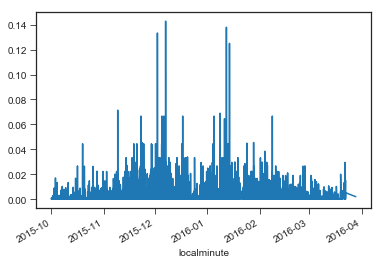

In [126]:
df_clean['marginal_rate'].plot()

4306

,marginal_change,cumul_value
localminute,,
2016-03-28 10:00:00,0.0,254184.0
2016-03-28 11:00:00,0.0,254184.0
2016-03-28 12:00:00,0.0,254184.0
2016-03-28 13:00:00,0.0,254184.0
2016-03-28 14:00:00,1008.0,255192.0


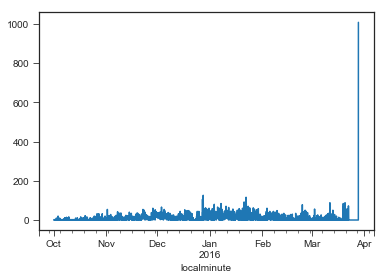

In [127]:
# step 8. Resample hourly, finding the new hourly marginal reading. Construct cumulative hourly readings as necessary.
# step 9. visualise cleaned readings. confirm that results are as intended
init_cumul_reading = df_clean['meter_value'].iloc[0]
hourly_cumul_readings = [init_cumul_reading]

df_resampled = df_clean['marginal_change'].resample('H').sum().fillna(0).to_frame()

for i in range(1, len(df_resampled.index)):
    hourly_cumul_readings.append(hourly_cumul_readings[i-1] + df_resampled['marginal_change'].iloc[i])

display(len(hourly_cumul_readings))

df_resampled = df_resampled.assign(cumul_value=hourly_cumul_readings)
df_resampled['marginal_change'].plot()
display(df_resampled.tail())

final plot for meterid 9639 shows that dropping points when marginal_rate >= threshold = 0.166 m^3/s, is not enough to clean the data. With long periods of silence and then a sudden increase in cumulative reading, the hourly marginal reading will spike as shown above. 

This can be dealt with using 1.5IQR filtering rule on each meterid.

In [128]:
def remove_outliers(df, coeff=1.5):
    # remove outliers using *IQR rule.
    tmp_df = df.loc[df.marginal_change > 1]
    Q1 = tmp_df['marginal_change'].quantile(0.25)
    Q3 = tmp_df['marginal_change'].quantile(0.75)
    IQR = Q3 - Q1
    
    #print(f'{Q1, Q3, IQR}')
    
    # Filtering Values between Q1-coeff*IQR and Q3+coeff*IQR
    return df.query('(@Q1 - @coeff * @IQR) <= marginal_change <= (@Q3 + @coeff * @IQR)')

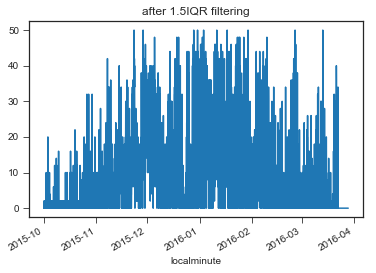

In [129]:
df_final = remove_outliers(df_resampled, coeff=1.5)
df_final['marginal_change'].plot(title='after 1.5IQR filtering')

NOTE: all dropping of values/rows must be done before finally reconstructing the cumulative values! in the above example, marginal_change is valid but cumul_value is not valid anymore. The processing is done in the proper order in the following section. The above section was to illustrate the need/usefulness for 1.5 IQR filtering.

### The above sections demonstrated the cleaning on one meterid. The below sections carries out all the cleaning steps on selected meterids and then compiles them into one csv file.

In [130]:
df_all = pd.read_csv('data/dataport-export_gas_oct2015-mar2016.csv')
df_all = df_all.set_index(pd.to_datetime(df_all['localminute']))
df_all = df_all.drop(columns='localminute')
groups = df_all.groupby('dataid')
keys = groups.groups.keys()  # keys: an iterable of dataids or meter ids
keys_list = list(keys)
print(keys_list)

[35, 44, 77, 94, 114, 187, 222, 252, 370, 483, 484, 661, 739, 744, 871, 1042, 1086, 1103, 1185, 1283, 1403, 1415, 1507, 1556, 1589, 1619, 1697, 1714, 1718, 1790, 1791, 1792, 1800, 1801, 2018, 2034, 2072, 2094, 2129, 2233, 2335, 2378, 2449, 2461, 2470, 2575, 2638, 2645, 2755, 2814, 2818, 2945, 2946, 2965, 2980, 3036, 3039, 3134, 3310, 3367, 3527, 3544, 3577, 3635, 3723, 3778, 3849, 3893, 3918, 4029, 4031, 4193, 4228, 4296, 4352, 4356, 4373, 4421, 4447, 4514, 4671, 4732, 4767, 4874, 4998, 5129, 5131, 5193, 5275, 5317, 5395, 5403, 5439, 5484, 5545, 5636, 5658, 5785, 5810, 5814, 5892, 5972, 6101, 6412, 6505, 6578, 6673, 6685, 6830, 6836, 6863, 6910, 7016, 7017, 7030, 7117, 7287, 7429, 7460, 7566, 7674, 7682, 7739, 7741, 7794, 7900, 7919, 7965, 7989, 8059, 8084, 8086, 8155, 8156, 8244, 8386, 8467, 8703, 8829, 8890, 8967, 9052, 9121, 9134, 9160, 9278, 9295, 9474, 9600, 9620, 9631, 9639, 9729, 9766, 9849, 9956, 9982]


In [131]:
# these meterids were visually inspected to have many suspicious spikes and dips in meter_value.
# to_remove = [1185, 1556, 2335, 2449, 3134, 3544, 4447, 4514,\
#              5129, 5403, 6836, 7030, 7117, 8156, 9134, 9639, 9982]

to_remove = []

low_samplefreq = [1874, 2645, 4671, 5545, 6101, 9620]

to_remove.extend(low_samplefreq) 

display(to_remove, len(to_remove))

# final meters to use for analysis
to_keep = [elem for elem in keys_list if elem not in to_remove]

df_all_cleaned = pd.DataFrame()

for meterid in keys_list:
    df_i = groups.get_group(meterid)
    df_no_mal = remove_mal_data(df_i)
    df_no_negative_marginal = remove_negative_marginal(df_no_mal)
    df_new = get_rate_of_increase(df_no_negative_marginal)
    df_clean = remove_large_increments(df_new)
    #df_clean = remove_outliers(df_clean, coeff=1.5)  
    # shouldn't do 1.5IQR filtering on 6months; only on 1 month or less, due to seasonalities.
    
    # resample by hour, reconstruct cumulative values from marginal values
    init_cumul_reading = df_clean['meter_value'].iloc[0]
    hourly_cumul_readings = [init_cumul_reading]

    df_resampled = df_clean['marginal_change'].resample('H').sum().fillna(0).to_frame()

    for i in range(1, len(df_resampled.index)):
        hourly_cumul_readings.append(hourly_cumul_readings[i-1] + df_resampled['marginal_change'].iloc[i])

    df_resampled = df_resampled.assign(cumul_value=hourly_cumul_readings)
    
    df_final = df_resampled.assign(meterid=[meterid for i in range(len(df_resampled))]) # add meterid column
    
    df_final = df_final.reset_index()
    
    df_all_cleaned = df_all_cleaned.append(df_final, ignore_index=True)

display(df_all_cleaned.head())

[1874, 2645, 4671, 5545, 6101, 9620]

6

C:\Users\Melvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


,localminute,marginal_change,cumul_value,meterid
0,2015-10-01 05:00:00,0.0,93470.0,35
1,2015-10-01 06:00:00,0.0,93470.0,35
2,2015-10-01 07:00:00,0.0,93470.0,35
3,2015-10-01 08:00:00,0.0,93470.0,35
4,2015-10-01 09:00:00,0.0,93470.0,35


In [132]:
display(len(df_all_cleaned), df_all_cleaned.tail())

606293

,localminute,marginal_change,cumul_value,meterid
606288,2016-03-31 12:00:00,0.0,119638.0,9982
606289,2016-03-31 13:00:00,0.0,119638.0,9982
606290,2016-03-31 14:00:00,0.0,119638.0,9982
606291,2016-03-31 15:00:00,0.0,119638.0,9982
606292,2016-03-31 16:00:00,72.0,119710.0,9982


In [133]:
# step 10. save combined data into a new csv file.
df_all_cleaned.to_csv('data/cleaned.csv')